In [122]:
# Compare the skill of the model forecast using the depth data at the resolution of the DEM.

# Library imports.
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import savemat
import os
import rasterio

# Local imports.
from rasopt.Utilities import utils, land_cover_utils

In [148]:
# Plan files to compare.
gt_plan_fp = r"C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Orig_GT\Secchia_Panaro.p23.hdf"
sim_best_plan_fp = r"C:\Users\ay434\Box\Research\Flood_Sim_Materials\BayesOpt_Paper\Data\Secchia_Panaro.p23_camp0.05_2veg_30min.hdf"
# sim_best_plan_fp = r"C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf";

# Path to the DEM file.
dem_fname = r"DTM_1m.tif"
dem_fp = os.path.join(os.path.dirname(gt_plan_fp), dem_fname)
dem_fp = r"C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\DTM_1m.tif"

# Comparison timestep.
timestep = 120
dt = 0.5 # Hours.

# Downsample factor.
resample = 0.05

# HDF paths.
# Cell coordinate path.
cell_coord_path = 'Geometry/2D Flow Areas/Secchia_Panaro/Cells Center Coordinate'

# Water depths path.
depth_path = ('Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/'
              '2D Flow Areas/Secchia_Panaro/Depth')

# Manning's n calibration table path.
cal_table_path = "Geometry/Land Cover (Manning's n)/Calibration Table"

# Cell facepoint index path.
cell_facepoint_idx_path = 'Geometry/2D Flow Areas/Secchia_Panaro/Cells FacePoint Indexes'

# Facepoint coordinate path.
facepoint_coord_path = 'Geometry/2D Flow Areas/Secchia_Panaro/FacePoints Coordinate'

In [149]:
# Time step with greatest flood extent.
gt_mesh_depths = utils.extract_depths(gt_plan_fp, depth_path, cell_coord_path)
Nt = len(gt_mesh_depths.columns) - 2

n_inun = np.zeros(Nt)
for t in range(Nt):
    col_name = f'Time_{t}'
    mesh_inun = gt_mesh_depths.loc[gt_mesh_depths[col_name] > 0.01, :]
    n_inun[t] = mesh_inun.shape[0]

timestep = np.argmax(n_inun)
print(timestep)

174


In [150]:
# Depth rasters at the resolution of the DEM raster.
gt_depths, gt_depth_path = land_cover_utils.terrain_water_depth(dem_fp, gt_plan_fp, cell_facepoint_idx_path, facepoint_coord_path,
                                        depth_path, cell_coord_path, timestep, out_fname_prefix='GT', nodata=-999.0, 
                                        cleanup_rasters=False, resample=resample)
sim_depths, sim_depth_path = land_cover_utils.terrain_water_depth(dem_fp, sim_best_plan_fp, cell_facepoint_idx_path, facepoint_coord_path,
                                        depth_path, cell_coord_path, timestep, out_fname_prefix='', nodata=-999.0,
                                        cleanup_rasters=False, resample=resample)


# Compute the sensitivity.
sensitivity = utils.inun_sensitivity(gt_depths, sim_depths, depth_cut=0.01)

# Type I and II Error.
typeI = utils.inun_error(gt_depths, sim_depths, 1, depth_cut=0.01)
typeII = utils.inun_error(gt_depths, sim_depths, 2, depth_cut=0.01)

# Fit.
fit = utils.inun_fit(gt_depths, sim_depths, depth_cut=0.01)

# Print results.
print('Sensitivity', sensitivity)
print('Type I', typeI)
print('Type II', typeII)
print('Fit', fit)

C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Orig_GT\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_174.tif
(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\BayesOpt_Paper\Data\Secchia_Panaro.p23_camp0.05_2veg_30min.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_174.tif
(1335, 1521)
Se

In [125]:
# Get top left and bottom right coordinates.
with rasterio.open(r'C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_222.tif', 'r') as ds:
    print('TOP LEFT', ds.transform * (0, 0))
    print('BOTTOM RIGHT', ds.transform * (ds.width, ds.height))
    

TOP LEFT (652093.732276195, 4972124.219236948)
BOTTOM RIGHT (682516.732276195, 4945405.219236948)


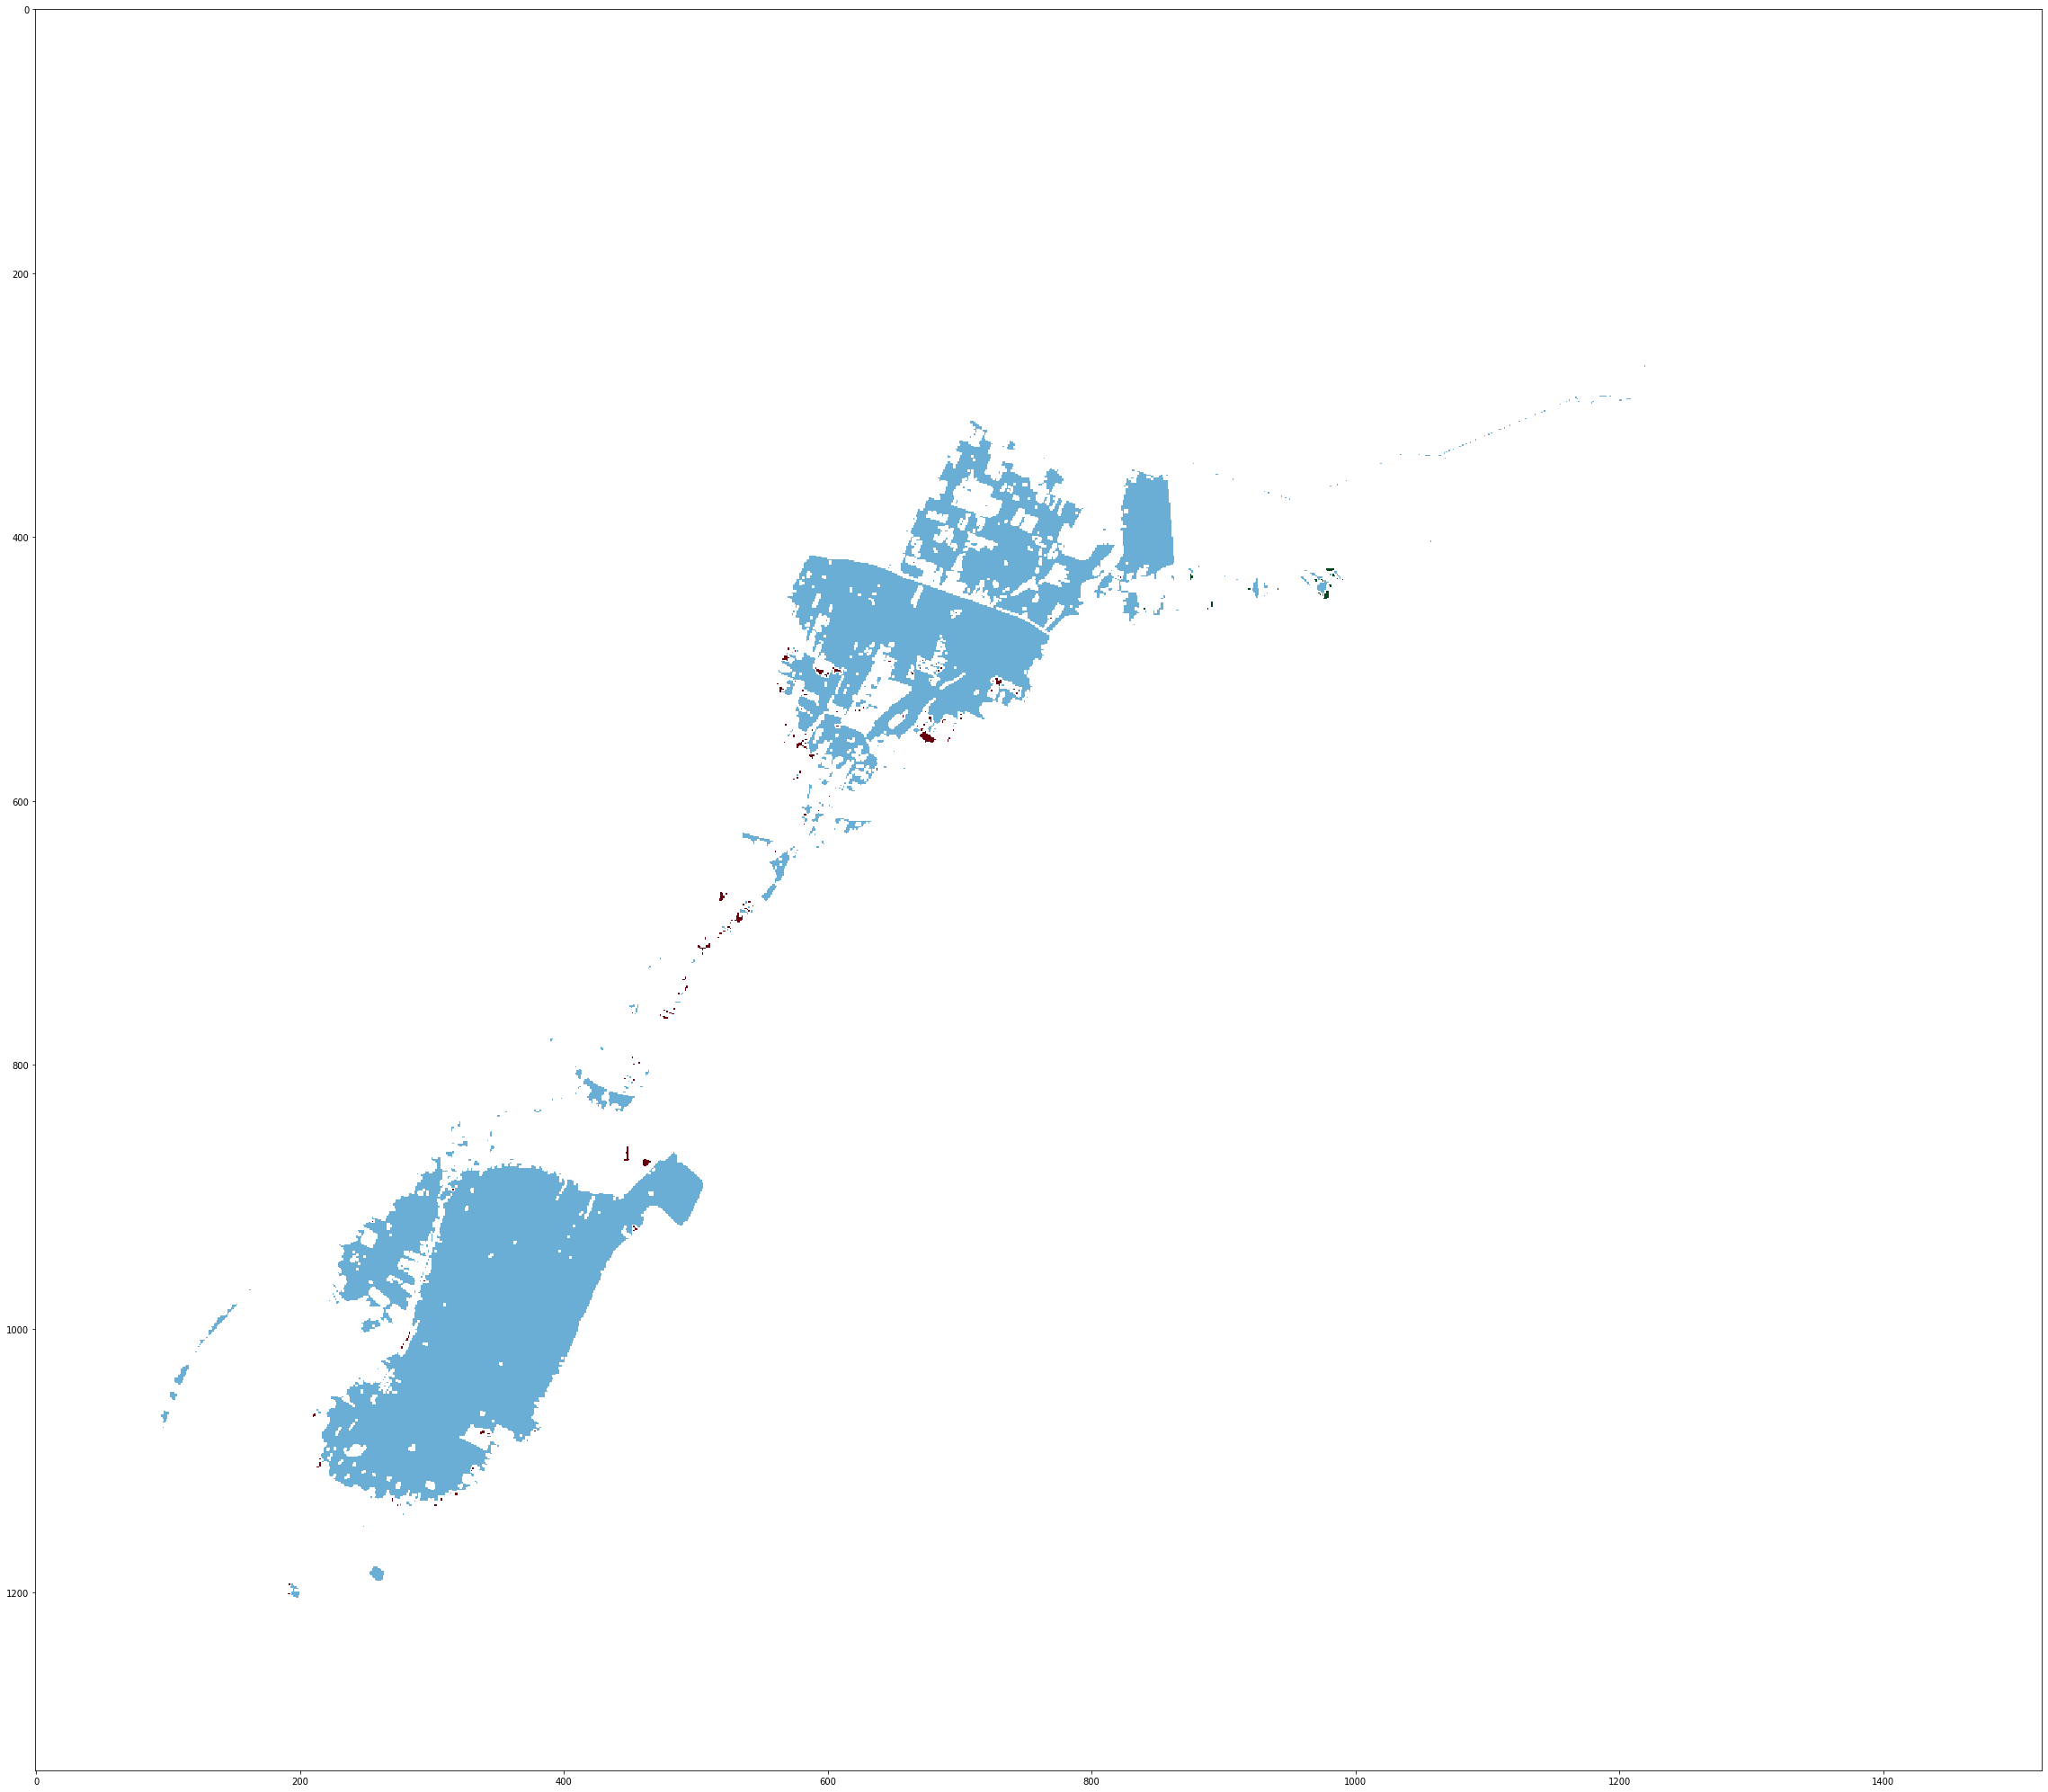

In [151]:
# Plot the mismatch.
out_path = r"C:\Users\ay434\Box\Research\Flood_Sim_Materials\BayesOpt_Paper\Data\1_veg"
suffix = '1veg_camp005'
gt_inun = gt_depths.copy()
gt_inun[gt_inun >= 0.01] = 1
gt_inun[gt_inun < 0.01] = 0
gt_bool = np.array(gt_inun, dtype=bool)
gt_inun[gt_inun == 0] = np.nan

sim_inun = sim_depths.copy()
sim_inun[sim_inun >= 0.01] = 1
sim_inun[sim_inun < 0.01] = 0
sim_bool = np.array(sim_inun, dtype=bool)
sim_inun[sim_inun == 0] = np.nan

gt_and_sim = np.logical_and(gt_bool, sim_bool).astype(float)
gt_and_sim[gt_and_sim == 0] = np.nan
savemat(os.path.join(out_path, f'gt_and_sim_{suffix}.mat'), {f'gt_and_sim': gt_and_sim})

gt_and_notsim = np.logical_and(gt_bool, ~sim_bool).astype(float)
gt_and_notsim[gt_and_notsim == 0] = np.nan
savemat(os.path.join(out_path, f'gt_and_notsim_{suffix}.mat'), {f'gt_and_notsim': gt_and_notsim})

notgt_and_sim = np.logical_and(~gt_bool, sim_bool).astype(float)
notgt_and_sim[notgt_and_sim == 0] = np.nan
savemat(os.path.join(out_path, f'notgt_and_sim_{suffix}.mat'), {f'notgt_and_sim': notgt_and_sim})

gt_or_sim = np.logical_or(gt_bool, sim_bool).astype(float)
gt_or_sim[gt_or_sim == 0] = np.nan
savemat(os.path.join(out_path, f'gt_or_sim_{suffix}.mat'), {f'gt_or_sim': gt_or_sim})

gt_xor_sim = np.logical_xor(gt_bool, sim_bool).astype(float)
gt_xor_sim[gt_xor_sim == 0] = np.nan
savemat(os.path.join(out_path, f'gt_xor_sim_{suffix}.mat'), {f'gt_xor_sim': gt_xor_sim})

fig, ax = plt.subplots(figsize=(40,40))
# ax.imshow(gt_inun, vmin=0, vmax=2)
# ax.imshow(sim_inun, vmin=1, vmax=2)
ax.imshow(gt_and_sim, cmap='Blues', vmin=0, vmax=2)
ax.imshow(gt_and_notsim, cmap='Reds', vmin=0, vmax=1)
ax.imshow(notgt_and_sim, cmap='Greens', vmin=0, vmax=1)
parameters = {'axes.labelsize': 25,
          'axes.titlesize': 35}
plt.rcParams.update(parameters)

In [35]:
# Get the total number of timesteps. 
depths = utils.extract_depths(gt_plan_fp, depth_path, cell_coord_path)
Nt = depths.shape[1] - 2
print(Nt)

283


In [36]:
# Critical depth comparison.
depth_cut = 0.1

# Time to critical depth arrays.
gt_tc = np.zeros_like(gt_depths)
sim_tc = np.zeros_like(gt_depths)

timesteps = list(range(Nt))
for t in range(0,Nt,2):
    print('Processing Timestep:', t)
    timestep = t
    # Get the depths for that timestep.
    gt_depths, gt_depth_path = land_cover_utils.terrain_water_depth(dem_fp, gt_plan_fp, cell_facepoint_idx_path, facepoint_coord_path,
                                        depth_path, cell_coord_path, timestep, out_fname_prefix='GT', nodata=-999.0, cleanup_rasters=True,
                                                                   resample=resample)
    sim_depths, sim_depth_path = land_cover_utils.terrain_water_depth(dem_fp, sim_best_plan_fp, cell_facepoint_idx_path, facepoint_coord_path,
                                            depth_path, cell_coord_path, timestep, out_fname_prefix='', nodata=-999.0, cleanup_rasters=True,
                                                                     resample=resample)
    # Cells that exceed cutoff depth.
    gt_exceed = gt_depths > depth_cut
    sim_exceed = sim_depths > depth_cut
    
    # Set gt_tc or sim_tc cells to the timestep when the first surpass the depth cut.
    gt_tc_mask = gt_tc > 0 # Already assigned cells.
    sim_tc_mask = sim_tc > 0 # Already assigned cells.
    gt_tc[gt_exceed & ~gt_tc_mask] = t
    sim_tc[sim_exceed & ~sim_tc_mask] = t
    
    print('Completed Timstep:', t, '\n')

Processing Timestep: 0
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Orig_GT\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_0.tif
(1335, 1521)
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Sim\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_0.tif
(1335, 1521)
Compl

DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_16.tif
(1335, 1521)
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Sim\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_16.tif
(1335, 1521)
Completed Timstep: 16 

Processing Timestep: 18
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Orig_GT\S

(1335, 1521)
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Sim\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_32.tif
(1335, 1521)
Completed Timstep: 32 

Processing Timestep: 34
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Orig_GT\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Fil

DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_48.tif
(1335, 1521)
Completed Timstep: 48 

Processing Timestep: 50
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Orig_GT\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_50.tif
(1335, 1521)
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Sim\S

(1335, 1521)
Completed Timstep: 64 

Processing Timestep: 66
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Orig_GT\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_66.tif
(1335, 1521)
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Sim\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Fil

DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_82.tif
(1335, 1521)
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Sim\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_82.tif
(1335, 1521)
Completed Timstep: 82 

Processing Timestep: 84
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Orig_GT\S

(1335, 1521)
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Sim\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_98.tif
(1335, 1521)
Completed Timstep: 98 

Processing Timestep: 100
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Orig_GT\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Fi

(1335, 1521)
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Sim\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_114.tif
(1335, 1521)
Completed Timstep: 114 

Processing Timestep: 116
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Orig_GT\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_

(1335, 1521)
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Sim\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_130.tif
(1335, 1521)
Completed Timstep: 130 

Processing Timestep: 132
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Orig_GT\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_

(1335, 1521)
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Sim\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_146.tif
(1335, 1521)
Completed Timstep: 146 

Processing Timestep: 148
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Orig_GT\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_

(1335, 1521)
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Sim\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_162.tif
(1335, 1521)
Completed Timstep: 162 

Processing Timestep: 164
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Orig_GT\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_

(1335, 1521)
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Sim\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_178.tif
(1335, 1521)
Completed Timstep: 178 

Processing Timestep: 180
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Orig_GT\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_

(1335, 1521)
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Sim\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_194.tif
(1335, 1521)
Completed Timstep: 194 

Processing Timestep: 196
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Orig_GT\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_

(1335, 1521)
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Sim\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_210.tif
(1335, 1521)
Completed Timstep: 210 

Processing Timestep: 212
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Orig_GT\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_

(1335, 1521)
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Sim\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_226.tif
(1335, 1521)
Completed Timstep: 226 

Processing Timestep: 228
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Orig_GT\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_

(1335, 1521)
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Sim\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_242.tif
(1335, 1521)
Completed Timstep: 242 

Processing Timestep: 244
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Orig_GT\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_

(1335, 1521)
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Sim\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_258.tif
(1335, 1521)
Completed Timstep: 258 

Processing Timestep: 260
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Orig_GT\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_

(1335, 1521)
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Sim\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_274.tif
(1335, 1521)
Completed Timstep: 274 

Processing Timestep: 276
C:\Users\ay434\Documents\10_min_Runs\Secchia_flood_2014_30min_Orig_GT\Secchia_Panaro.p23.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_

In [37]:
delta_save_fname = 'delta_30min_1veg_camp0.05.npy'

125.0
233448.0


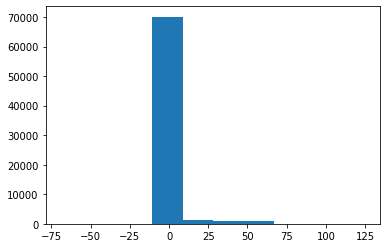

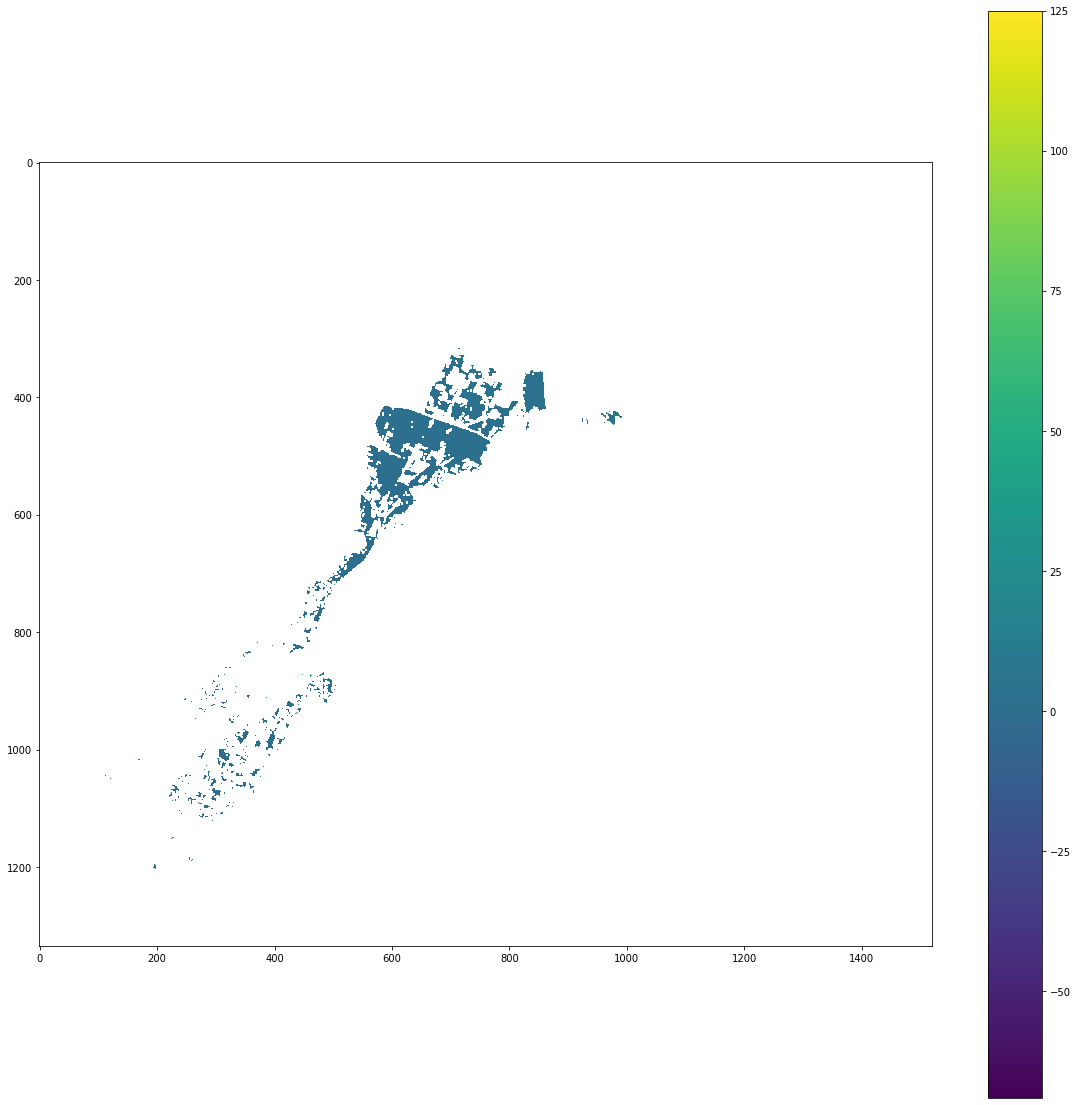

In [38]:
# Difference in time to critical depth.
delta_tc = (gt_tc - sim_tc) * dt
print(np.max(delta_tc[delta_tc > 0]))

print(np.sum(delta_tc))

fig, ax = plt.subplots()
ax.hist(delta_tc[delta_tc != 0])

delta_tc_plot = delta_tc.copy()
delta_tc_plot[delta_tc_plot == 0] = np.nan
fig, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(delta_tc_plot)
plt.colorbar(im)

np.save(delta_save_fname, delta_tc)

### 